## Dataset Import

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zzettrkalpakbal/full-filled-brain-stroke-dataset")


100%|██████████| 52.1k/52.1k [00:00<00:00, 1.15MB/s]

Extracting files...


### Importing Libaries

In [109]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import shap
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold



plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

In [31]:
df = pd.read_csv("full_data.csv")

In [32]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [33]:
df.shape

(4981, 11)

In [34]:
df.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [35]:
df.loc[df.duplicated()]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


### No duplicates or NA values in dataset

# Univariate Analysis

Text(0.5, 0.98, 'Numerical Feature Distributions')

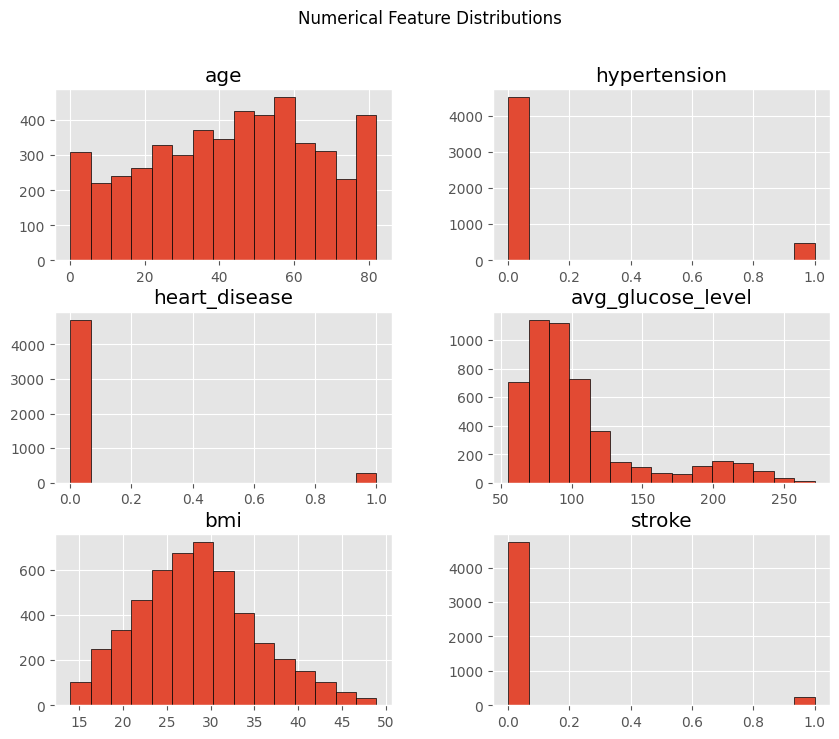

In [36]:
axes = df.hist(figsize=(10,8), edgecolor='black', bins=15)
plt.suptitle("Numerical Feature Distributions")

In [60]:
df['stroke'].value_counts() # very imbalanced

stroke
0    4733
1     248
Name: count, dtype: int64

In [38]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

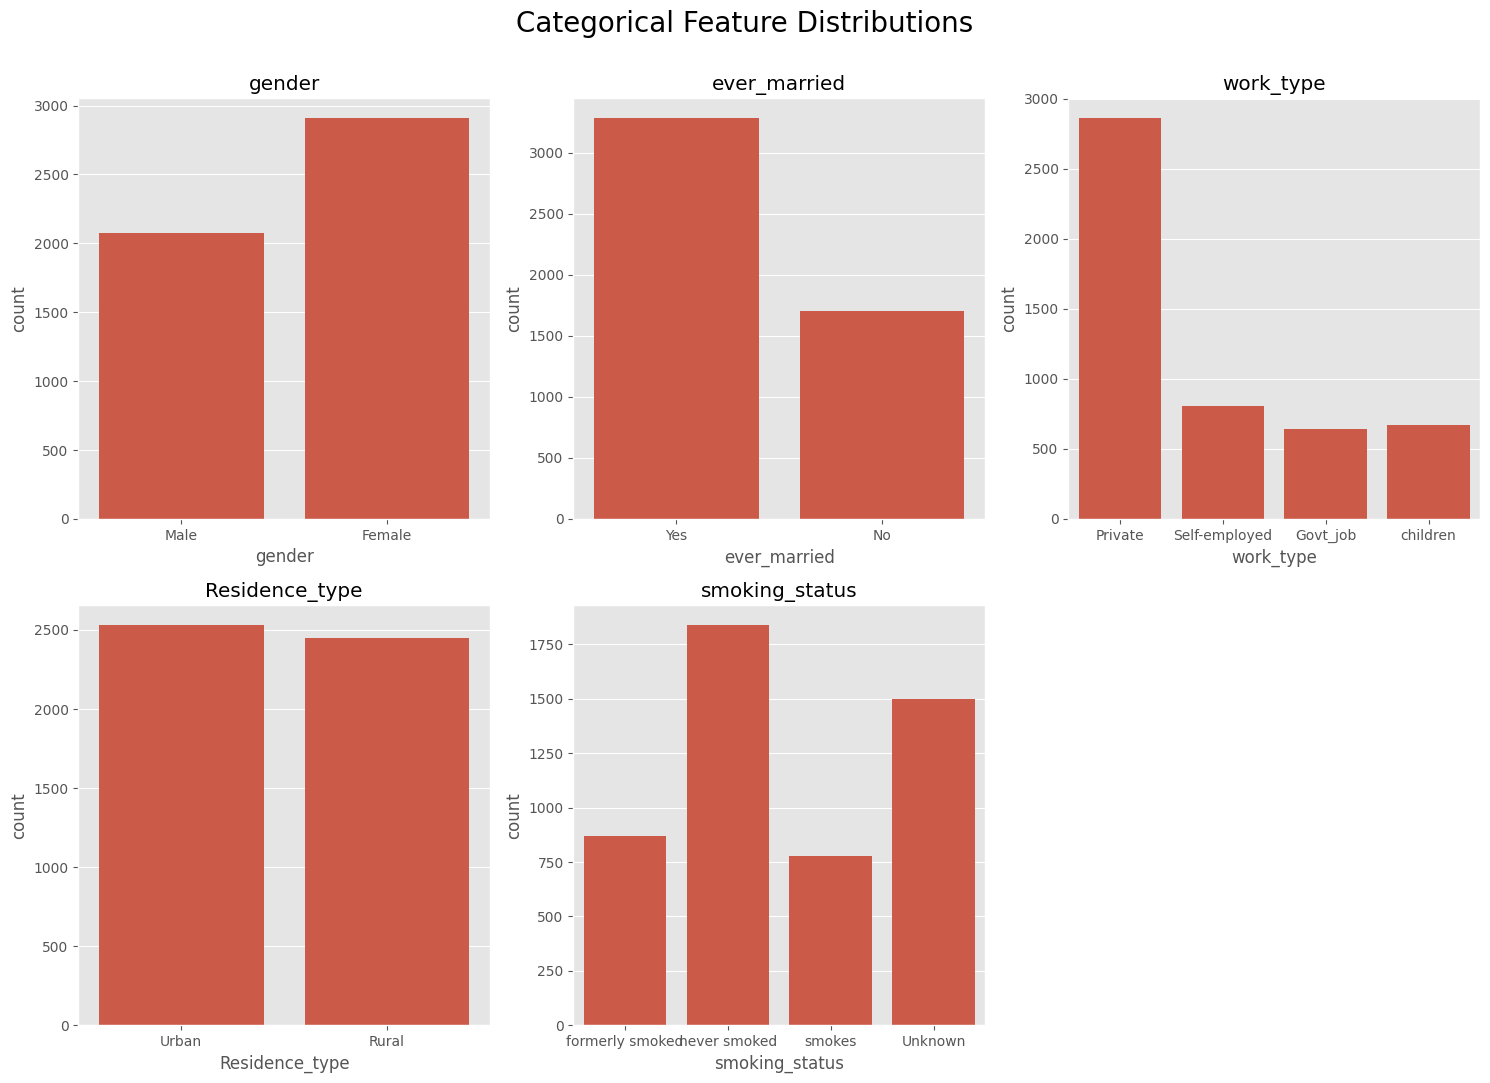

In [47]:
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

# Set up the figure and axes
num_cols = len(categorical_columns)
rows = int(np.ceil(num_cols))  # Adjust based on preference
fig, axes = plt.subplots(rows, min(num_cols, 3), figsize=(15, 5 * rows))

# Flatten axes array in case of a single row
axes = axes.flatten() if num_cols > 1 else [axes]

# Plot each categorical feature
for i, col in enumerate(categorical_columns):
    sns.countplot(x=df[col], ax=axes[i])
    axes[i].set_title(col)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Categorical Feature Distributions", fontsize=20, y=1.02)
plt.show()


# Bivariate

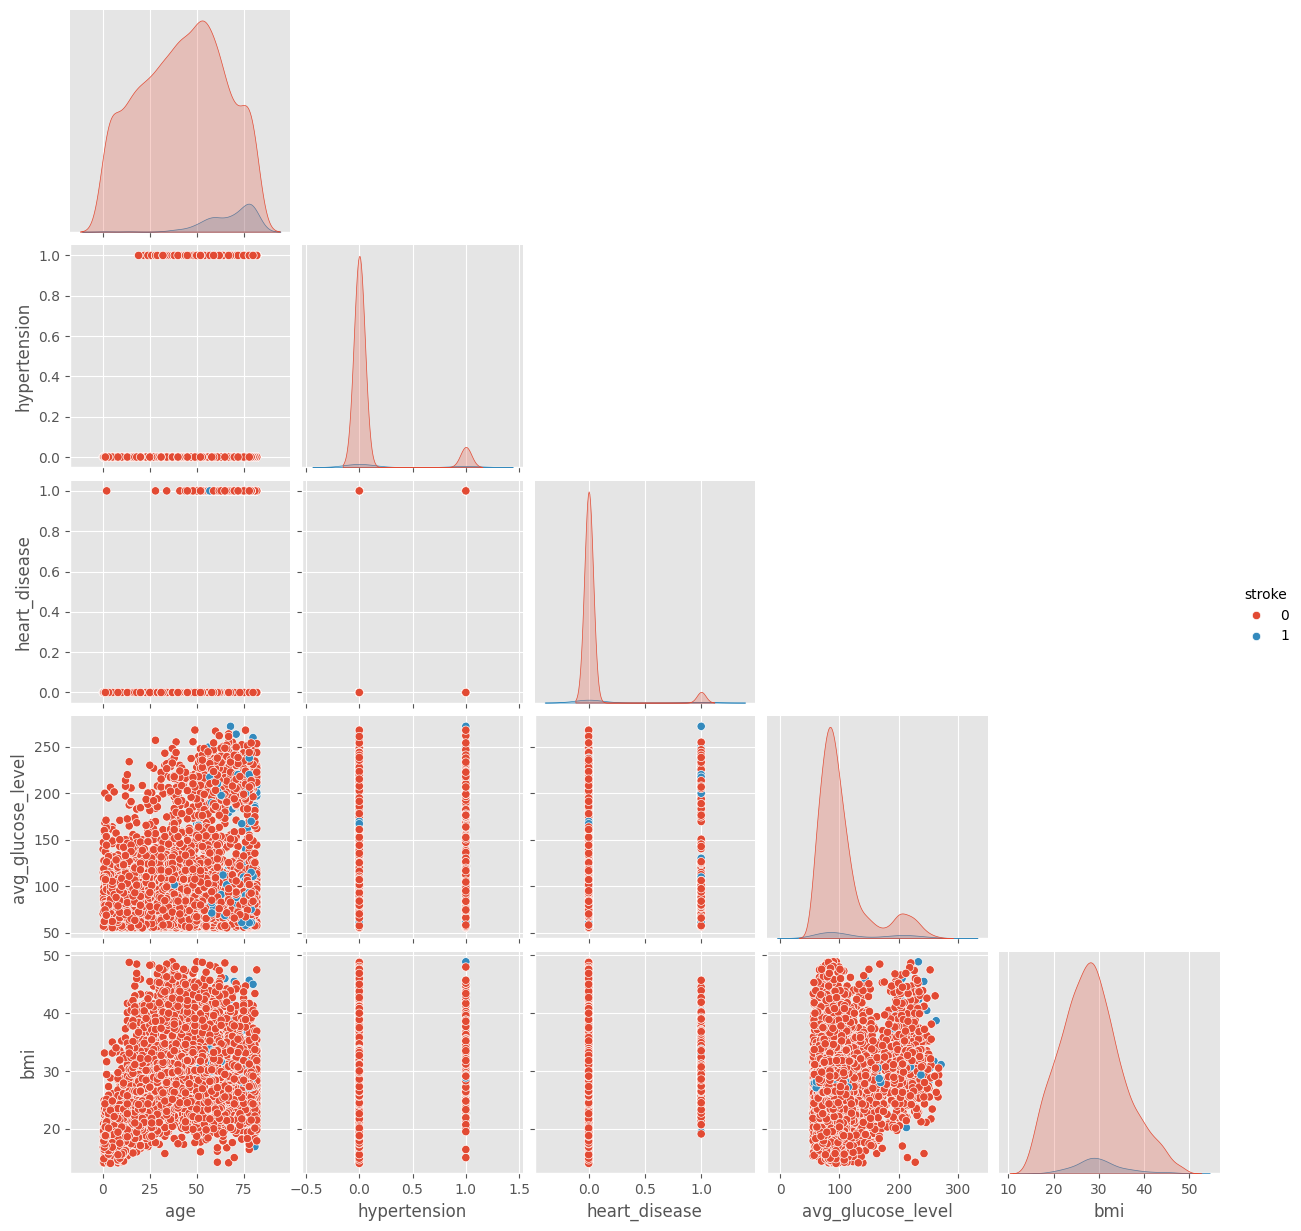

In [48]:
sns.pairplot(df, hue='stroke', diag_kind='kde', corner='True')
plt.show()

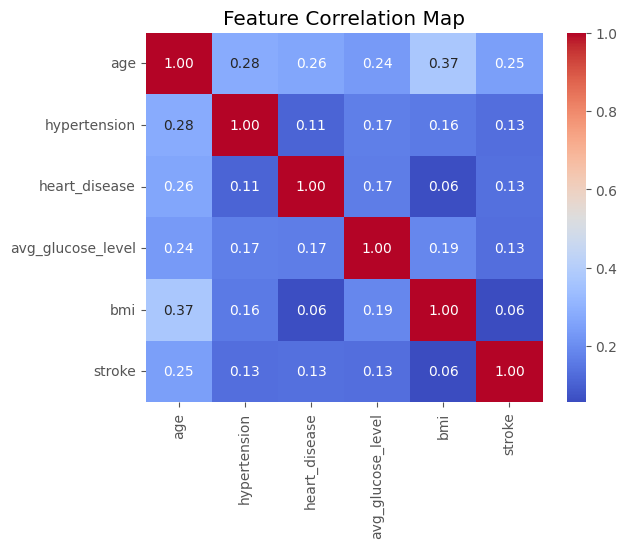

In [49]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Map")
plt.show()

In [54]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

# Data Preprocessing

In [56]:
# Encode categorical features
label_encoders = {}  # Dictionary to store encoders
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le 


In [111]:
X = df.drop(columns=['stroke'])  # Features
y = df['stroke']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) #stratify to 


# Baseline Model Evaluation (SVC)

In [112]:
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42)
svm_model.fit(X_train, y_train)


SVC(class_weight='balanced', random_state=42)

## Evaluation

In [113]:
# Predictions
y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)




Accuracy: 0.7392176529588766
Precision: 0.13541666666666666
Recall: 0.78
F1-score: 0.23076923076923078


Baseline ^
Most Important (Personal Goals):
- Accuracy: 0.7392
  - Good but not representitive due to imbalances
  - Trying to still keep high
- Recall: 0.78
  - Reducing False Negatives is a must. Good thing it is already high
  - Trying ot Improve
- Don't Hurt Precision too much (False Positives)
  - 

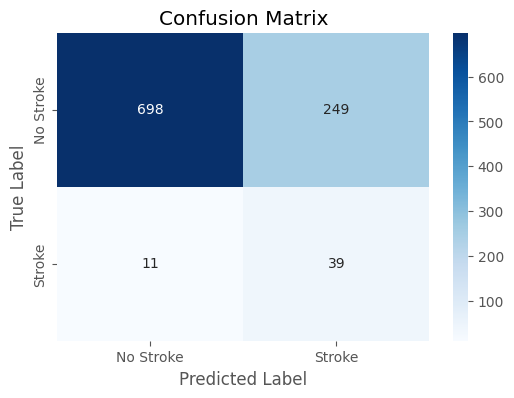

In [114]:
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [115]:
# Trying SHAP

# Initialize SHAP explainer
# explainer = shap.Explainer(svm_model.predict, X_test)

# shap_values = explainer(X_test)

# shap.summary_plot(shap_values, X_test)

# TOOK TOO LONG, DID NOT TRY

### Technique 1: Removing Highest Negative Permutation Importance + Standardizing Numeric Features

In [117]:

# Compute permutation importance
perm_importance = permutation_importance(svm_model, X_test, y_test, scoring='f1')

# Create a DataFrame
importance_df = pd.DataFrame({'Feature': X_test.columns, 'Importance': perm_importance.importances_mean})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display feature importance
print(importance_df)

             Feature  Importance
1                age    0.134659
7  avg_glucose_level    0.003826
8                bmi    0.000857
3      heart_disease    0.000136
0             gender    0.000000
6     Residence_type    0.000000
5          work_type   -0.000360
2       hypertension   -0.000908
4       ever_married   -0.000908
9     smoking_status   -0.002659


In [118]:
'''
4       ever_married   -0.000908
9     smoking_status   -0.003560
'''
# Getting rid of these ^

clean_df = df.drop(columns=['ever_married', 'smoking_status'])

In [119]:
X = clean_df.drop(columns=['stroke'])  # Features
y = df['stroke']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) #stratify to 

scaler = StandardScaler()
X[['age', 'avg_glucose_level', 'bmi']] = scaler.fit_transform(X[['age', 'avg_glucose_level', 'bmi']])

svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

f1 = f1_score(y_test, y_pred)
# Evaluate model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1)



Accuracy: 0.7382146439317954
F1-score: 0.23460410557184752


Marginal Improvement (~ +0.004 F1 Score) ^^

### Technique 2: Oversampling Minority Class + Stratified CV + Hyperparameter tuning w/ GridsearchCV (FAILED)

In [103]:
# Oversampling to fix Dataset Unbalance with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Stratified Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10],
    'kernel': ['rbf']
}

grid_search = GridSearchCV(SVC(class_weight='balanced'), param_grid, scoring='f1', cv=cv)
grid_search.fit(X_res, y_res)

# Best parameters and model
print(grid_search.best_params_)
svm_model = grid_search.best_estimator_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [104]:
svm_model.fit(X_res, y_res)

SVC(C=10, class_weight='balanced', gamma=0.1)

In [105]:

y_pred = svm_model.predict(X_test)

f1 = f1_score(y_test, y_pred)
# Evaluate model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1)


Accuracy: 0.8916750250752257
F1-score: 0.1


Nuked the F1 Score ^ (~ -0.13)

### Technique 3: HyperparameterTuning w/ GridSearchCV ONLY

In [106]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10],
    'kernel': ['rbf']
}

grid_search = GridSearchCV(SVC(class_weight='balanced'), param_grid, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)



# Best parameters and model
print(grid_search.best_params_)
svm_model = grid_search.best_estimator_

{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}


In [110]:
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.753259779338014
Precision: 0.14492753623188406
Recall: 0.8
F1-score: 0.24539877300613497


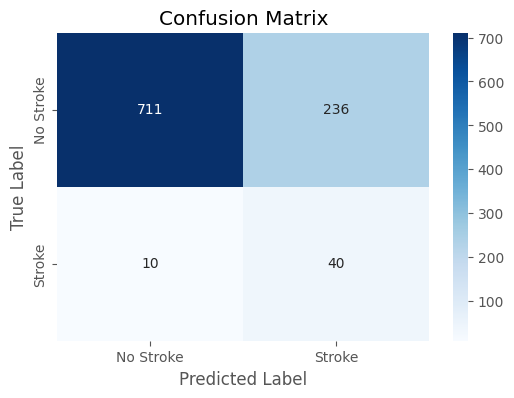